<a href="https://colab.research.google.com/github/cyrus2281/video-rag/blob/main/notebook/video_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video RAG

In this notebook, each section required in building a complete RAG from a video will be explained.

**Make sure to open this notebook in Goolge Colab Notebook. You can use the button at the top of the page to open the noteboo in Colab.**

>[Video RAG](#scrollTo=rEEnJo39s4VA&uniqifier=2)

>>[Theory](#scrollTo=1w05CZCfu5lj&uniqifier=2)

>>>[What's a video?](#scrollTo=n9T-HjbBu1zB&uniqifier=2)

>>>[Video Rag Requirements](#scrollTo=ixFuTSoRvTHp&uniqifier=2)

>>>>[Jina Clip V1 - Multimodal Embedding Model](#scrollTo=sF35N4AHwEd1&uniqifier=2)

>>>>[ChromaDB - Vector Database](#scrollTo=VL0lkKxZxh3P&uniqifier=2)

>>>>[Whisper - Speech to text model](#scrollTo=7uORbaDbyaAd&uniqifier=2)

>>>[Video RAG process flow](#scrollTo=MACaH-l9zoT5&uniqifier=2)

>>[Code](#scrollTo=T8Choepj-pWL&uniqifier=2)

>>>[Embeddings](#scrollTo=of_kLjp4znRn&uniqifier=2)

>>>>[Embedding Text and Images](#scrollTo=mmzhsMIB9gYw&uniqifier=2)

>>>>[Calculating Vector Similarity](#scrollTo=Cu5BIQIG9kvW&uniqifier=2)

>>>>[Adding Vectors together](#scrollTo=fJAUGnd79w-y&uniqifier=2)

>>>>[Processing Video](#scrollTo=NC4Ral9f-jez&uniqifier=2)

>>>>>[Processing Audio](#scrollTo=yNgvMtrNA8ca&uniqifier=2)

>>>>>[Processing Image Frames](#scrollTo=0BwpJimpBqqo&uniqifier=2)

>>>>[Embedding Video Segments](#scrollTo=ZqNqHwVEDtub&uniqifier=2)

>>>>>[Creating embedding](#scrollTo=b4elu08LHTmR&uniqifier=2)

>>>>>[Storing Embeddings](#scrollTo=9Y7mV0_JHXxy&uniqifier=2)

>>>>[Search & Retrieval](#scrollTo=LY9jUv64Hicm&uniqifier=2)



## Theory

### What's a video?

Video = Frames + Audio

Frames = series of images

Audio = Sound + Speech


### Video Rag Requirements

To do retrieval on a video, you'd need
- Multimodal embedding model: An embedding model that supports both images and texts
- A vector database: To store the vector embeddings

> **NOTE:** Your image and text embeddding must be in the same vector space meaning you can't use 2 different embedding models one for image and one for text, otherwise you'll loose the semantic meaning when combing the two vectors.

#### Jina Clip V1 - Multimodal Embedding Model

In this notebook, I'll be using the [Jina Clip V1 Embedding model](https://jina.ai/embeddings/) from [Jina.ai](https://jina.ai/) which as of writing this notebook, offers free API keys with 1 million token.

I'll be using [Langchain's embedding](https://python.langchain.com/v0.2/docs/concepts/#embedding-models) wrapper for Jina embedding models. This allows you to easily swap with any other multimodal embedding model provider as long as there's a langchain wrapper for it.

#### ChromaDB - Vector Database

In this notebook, I'll be using [Chroma DB](https://docs.trychroma.com/getting-started) for the vector database.

Similar to the embedding model, I'll be using [Langchain's vector store](https://python.langchain.com/v0.2/docs/concepts/#vector-stores) wrapper for chromaDB vector database. You can swap ChromaDB with any other vector database that has a langchain wrapper.

#### Whisper - Speech to text model

In this notebook, I'll be using a local version of the [OpenAI Whisper](https://openai.com/index/whisper/) model to convert speech to text.

Running the Whisper model requires GPU, you can alternativly use the hosted version on OpenAI's servers.

> **NOTE:** Whisper is a **speech-to-text** model, not **audio-to-text** model. meaning by using this model, we'll lose in data in the audio that is not natural language speech. i.e. if there's a barking sound or a crying sound, the model will not transcribe those. If you care about being able to do a search based on those, you'd need to use a model that is audio-to-text

Main reason for chosing this model is that it's API support creating a transcription for a video.

### Video RAG process flow

**Ingestion flow**
- Load video onto disk
- extract video audio
- transribe video's audio using Whisper
- Split video buffer's based on the transcription
- create a list of frame + transcription
- embed the image frame and the transcription text using the same embedding model
- Perform an element wise add operation to combine the verctors
- Create metadata for the embedding that would also for loading those frames from the original video
- store the combined embedding + metadata in the vector database


**Search flow**

- Embed the query using the same embedding model
- Use **cosine similarity** algorithm to perform a vector search
- Create a segment clip from frame metadata



## Code

### Embeddings

First installing the dependencies required for running this notebook that are not already included with Google Colab notebooks (Note: a lot more dependnecies are used in this notebook that you'd need to install if running locally)

In [ ]:
!pip install -U langchain-community chromadb langchain langchain_chroma openai-whisper moviepy webvtt-py

importing modules

In [4]:
import requests
from langchain_community.embeddings import JinaEmbeddings
from numpy import dot
from numpy.linalg import norm
from PIL import Image
import os

#### Embedding Text and Images

Jina embedding model API key from https://jina.ai/embeddings

In [5]:
import getpass
jina_api_key = getpass.getpass()

··········


Using `jina-clip-v1` as it's a multi-modal embedding model

In [6]:
embeddings_function = JinaEmbeddings(
    jina_api_key=jina_api_key, model_name="jina-clip-v1"
)

Testing embedding a piece of text

In [11]:
query_result = embeddings_function.embed_query("This is a test document.")

print(query_result[:10])

[-0.032044545, -0.003538295, 0.038607135, -0.019625466, -0.018545546, 0.021266114, 0.046311945, 0.0025193803, -0.053995993, 0.04635348]


In [9]:
len(query_result)

768

Downloading some images to test on

> **NOTE:** All images used in this notebook are a proeprty of their respective owners. Original url has been used for all media

Image:


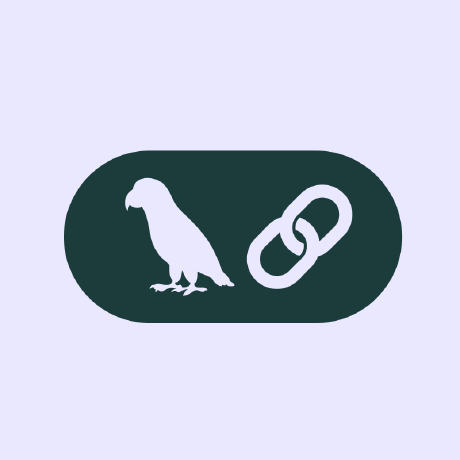

In [10]:
image = "https://avatars.githubusercontent.com/u/126733545?v=4"

im = Image.open(requests.get(image, stream=True).raw)
print("Image:")
display(im)

In [13]:
image_result = embeddings_function.embed_images([image])
print(image_result[0][:10])

[0.018377269, 0.022349516, -0.00014286977, 0.038313456, -0.009848177, -0.0051939017, 0.010462752, -0.02258935, 0.024028353, -0.09725262]


In [14]:
len(image_result[0])

768

#### Calculating Vector Similarity

Creating a cosine similarty function to calculate the distance between the 2 vectors.

$$
\begin{align*}
\text{cosine similarity}
&= \cos(\theta)  \\
&= \frac{A \cdot B}{\|A\| \|B\|} \\
&= \frac{\sum_{i=1}^n{A_iB_i}}{\sum_{i=1}^n{A_i^2} \sum_{i=1}^n{B_i^2}} \\
\end{align*}
$$

> **Note**: The type of vector similarity algorithm you use is important when combine vectors together. Cosine similarity works with element-wise sum

- Values closer to 1 are very similar
- Values closer to -1 are very disimilar

In [16]:
def get_cosine_similarity(vec1, vec2):
   return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

We do not expect the test text and test image to be similar

In [17]:
get_cosine_similarity(image_result, query_result)

array([-0.00246221])

We expect the description of the image and the image be similar

In [18]:
query_result = embeddings_function.embed_query("A white bird and a chain in a green logo and white background")

In [19]:
get_cosine_similarity(image_result, query_result)

array([0.34192012])

Now let's try this with different text and images

In [20]:
text_sample_driving_car = embeddings_function.embed_query("driving a fast car")
text_sample_bussiness_man = embeddings_function.embed_query("a bussiness man")
text_sample_eating_burger = embeddings_function.embed_query("eating a hamburger")

In [21]:
image_sample_cartoon_car = embeddings_function.embed_images(["https://iheartcraftythings.com/wp-content/uploads/2021/04/Car-DRAWING-%E2%80%93-STEP-10.jpg"])[0] # Cartoonish car
image_sample_cartoon_mouse = embeddings_function.embed_images(["https://www.loudegg.com/wp-content/uploads/2020/10/Mickey-Mouse.jpg"])[0] # micky mouse cartoon
image_sample_real_car = embeddings_function.embed_images(["https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg/375px-2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg"])[0] # real car
image_sample_suit = embeddings_function.embed_images(["https://media.istockphoto.com/id/1352080196/photo/portrait-of-friendly-mature-businessman.jpg?s=612x612&w=0&k=20&c=lAg5YrqNXcIXr1yW3w9SyGJGIShNKto9Y-D8_LxKepQ="])[0] # man in a suit

We expect the following to have a high similarity

In [22]:
# High
print(1, get_cosine_similarity(text_sample_driving_car, image_sample_cartoon_car))
print(2, get_cosine_similarity(text_sample_driving_car, image_sample_real_car))
print(3, get_cosine_similarity(text_sample_bussiness_man, image_sample_suit))

1 0.1280657156562841
2 0.061136122502846106
3 0.21269899588084615


We expect the following to have a low similarity

In [23]:
# Low
print(1, get_cosine_similarity(text_sample_driving_car, image_sample_suit))
print(2, get_cosine_similarity(text_sample_bussiness_man, image_sample_real_car))
print(3, get_cosine_similarity(text_sample_eating_burger, image_sample_real_car))

1 -0.030612099284530552
2 -0.0036039519146584082
3 -0.08670890367969213


#### Adding Vectors together

There are multiple ways you can combine 2 vectors without losing their semantic values. One of each is **element wise summation** which I'll be using in this notebook

In [24]:
def element_wise_sum(arr1, arr2):
  if len(arr1) != len(arr2):
    return None
  result = []
  for i in range(len(arr1)):
    result.append(arr1[i] + arr2[i])
  return result

Using a prompt with a combination of the 2 concepts to test if the vector sum is working

In [25]:
query = embeddings_function.embed_query("a bussiness man driving to work")

Sum example with high relevance

In [28]:
sum_high = element_wise_sum(text_sample_driving_car, image_sample_suit)
len(sum_high)

768

Sum example with low relevance

In [26]:
sum_low =element_wise_sum( text_sample_eating_burger, image_sample_cartoon_mouse)
len(sum_low)

768

In [29]:
print(1, get_cosine_similarity(query, sum_high))
print(2, get_cosine_similarity(query, sum_low))

1 0.4109807023917274
2 0.07448424062354295


Individual relevance test

In [30]:
print(1, get_cosine_similarity(query, text_sample_driving_car))
print(2, get_cosine_similarity(query, image_sample_suit))
print(3, get_cosine_similarity(query, text_sample_eating_burger))
print(4, get_cosine_similarity(query, image_sample_cartoon_mouse))
print(5, get_cosine_similarity(query, text_sample_bussiness_man))

1 0.40691570541505084
2 0.16533354184130875
3 0.07913873298605269
4 0.02630791585644979
5 0.628962813636243


Creating a local version of Chroma DB to store embeddings and performing vector search

> **NOTE:** ChromaDB using the `l2` search algorithm which doesn't work with element wise sum. Switch to `cosine` or `ip`.

In [31]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="video_rag_test",
    embedding_function=embeddings_function,
    persist_directory="./chroma_langchain_db",
    collection_metadata={"hnsw:space": "cosine"} # cosine, ip, l2
)

Utility function to add vectors with metadata to the database

In [32]:
import uuid

def add_vectors(vectors, values, metadatas=None, ids=None):
  ids = ids or [str(uuid.uuid4()) for _ in vectors]
  vector_store._collection.upsert(
      embeddings=vectors,
      documents=values,
      metadatas=metadatas,
      ids=ids,
  )

Adding all the individual and sum vectors to the database

In [33]:
add_vectors(
    [text_sample_driving_car, text_sample_bussiness_man, text_sample_eating_burger, image_sample_cartoon_car, image_sample_cartoon_mouse, image_sample_real_car, image_sample_suit, sum_high, sum_low],
    ["text_sample_driving_car", "text_sample_bussiness_man", "text_sample_eating_burger", "image_sample_cartoon_car", "image_sample_cartoon_mouse", "image_sample_real_car", "image_sample_suit", "sum_high", "sum_low"]
    )

Using ChromaDB to perform the same search we did manually earlier

In [34]:
results = vector_store.similarity_search_by_vector_with_relevance_scores(
    embedding=query, k=9
)

In [36]:
for doc, score in results:
    print(f"* {doc.page_content} - SIM={score:3f}")

* text_sample_bussiness_man - SIM=0.371037
* sum_high - SIM=0.589019
* text_sample_driving_car - SIM=0.593084
* image_sample_suit - SIM=0.834666
* image_sample_cartoon_car - SIM=0.883258
* image_sample_real_car - SIM=0.907444
* text_sample_eating_burger - SIM=0.920861
* sum_low - SIM=0.925516
* image_sample_cartoon_mouse - SIM=0.973692


Clearing the database for the next section

In [37]:
vector_store.reset_collection()

Now we essionally have everything we need to perform RAG on a frame of a video.

So now we need to convert a video to frames so we can do RAG over.

#### Processing Video

For this example, I'll be using the following Wildlife youtube video

- [Wildlife Over Lockdown | Short Wildlife Documentary](https://www.youtube.com/watch?v=MB29Pt5FFdA) By [The Biome Project](https://www.youtube.com/@TheBiomeProject)

You can use your own video, but then you'd also need update the example prompts.

Download and upload your video to `./wildlife-video.mp4`

Importing required modules

In [19]:
from pathlib import Path
import os
from os import path as osp
import json
import cv2
import webvtt
import whisper
from moviepy.editor import VideoFileClip
from PIL import Image
import base64
from io import StringIO, BytesIO
import textwrap
from typing import Iterator, TextIO, List, Dict, Any, Optional, Sequence, Union

##### Processing Audio

Creating a function to extract audio from a video and write it to disk

In [3]:
def extract_audio_from_video(video_path, audio_path):
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path)

Creating a function to transcribe audio to text with timestamps

In [2]:
def transcribe_audio(audio_file):
    model = whisper.load_model("small")
    options = dict(task="translate", best_of=1, language='en')
    results = model.transcribe(audio_file, **options)
    return results

Paths for the video, audio, and transcription

In [8]:
video_path = "wildlife-video.mp4"
audio_path = "wildlife-audio.mp3"
vtt_path = "wildlife-video.vtt"

Extracting the audio from the video

In [21]:
extract_audio_from_video(video_path, audio_path)

MoviePy - Writing audio in wildlife-audio.mp3


MoviePy - Done.


transcribing the audio and getting the segments with timestamps

In [5]:
transcribe = transcribe_audio(audio_path)
print(transcribe)

100%|███████████████████████████████████████| 461M/461M [00:05<00:00, 90.1MiB/s]
  checkpoint = torch.load(fp, map_location=device)



{'text': " 2020 has been a year unlike any other. Months of lockdown has caused many of us to reconnect with nature. In this film we will explore the wild world from a new perspective. How has nature thrived in our absence? And what new wildlife behaviour have we seen? Across the changing seasons we explore wildlife over lockdown. Spring in a surrey woodland and the first thing we noticed as lockdown set in we can hear the birds. Undisturbed by road traffic and the clamour of voices their chorus is louder than ever with blackcaps and chifchaffs both calling to attract mates. And in the undergrowth Oren, wait for wait his voice is ten times louder than a cockerel and for the first time we can hear him clearly. These woods are now alive with birdsong. But in spring it is nest building that is vitally important and high up in the canopy One species is taking advantage of the peace and quiet. Green woodpeckers busy excavating and renovating their nests but they are not alone up here. Great

In [6]:
transcribe["segments"]

[{'id': 0,
  'seek': 0,
  'start': 0.0,
  'end': 9.22,
  'text': ' 2020 has been a year unlike any other.',
  'tokens': [50364, 4808, 575, 668, 257, 1064, 8343, 604, 661, 13, 50825],
  'temperature': 0.0,
  'avg_logprob': -0.20119681287167676,
  'compression_ratio': 1.425414364640884,
  'no_speech_prob': 0.03886425867676735},
 {'id': 1,
  'seek': 0,
  'start': 9.22,
  'end': 15.72,
  'text': ' Months of lockdown has caused many of us to reconnect with nature.',
  'tokens': [50825,
   24255,
   82,
   295,
   17267,
   575,
   7008,
   867,
   295,
   505,
   281,
   30095,
   365,
   3687,
   13,
   51150],
  'temperature': 0.0,
  'avg_logprob': -0.20119681287167676,
  'compression_ratio': 1.425414364640884,
  'no_speech_prob': 0.03886425867676735},
 {'id': 2,
  'seek': 0,
  'start': 15.72,
  'end': 21.66,
  'text': ' In this film we will explore the wild world from a new perspective.',
  'tokens': [51150,
   682,
   341,
   2007,
   321,
   486,
   6839,
   264,
   4868,
   1002,
   4

Now we convert the transcription to vtt subtitle file

The following code block is taken from the [Multimodal RAG: Chat with Videos](https://www.deeplearning.ai/short-courses/multimodal-rag-chat-with-videos/) short course from [Deeplearning.ai](https://www.deeplearning.ai/)

These function are helper functions to convert the segment transcription to subtitle file

In [7]:
# This code block is from https://www.deeplearning.ai/short-courses/multimodal-rag-chat-with-videos/

# helper function for convert time in second to time format for .vtt or .srt file
def format_timestamp(seconds: float, always_include_hours: bool = False, fractionalSeperator: str = '.'):
    assert seconds >= 0, "non-negative timestamp expected"
    milliseconds = round(seconds * 1000.0)

    hours = milliseconds // 3_600_000
    milliseconds -= hours * 3_600_000

    minutes = milliseconds // 60_000
    milliseconds -= minutes * 60_000

    seconds = milliseconds // 1_000
    milliseconds -= seconds * 1_000

    hours_marker = f"{hours:02d}:" if always_include_hours or hours > 0 else ""
    return f"{hours_marker}{minutes:02d}:{seconds:02d}{fractionalSeperator}{milliseconds:03d}"

# a help function that helps to convert a specific time written as a string in format `webvtt` into a time in miliseconds
def str2time(strtime):
    # strip character " if exists
    strtime = strtime.strip('"')
    # get hour, minute, second from time string
    hrs, mins, seconds = [float(c) for c in strtime.split(':')]
    # get the corresponding time as total seconds
    total_seconds = hrs * 60**2 + mins * 60 + seconds
    total_miliseconds = total_seconds * 1000
    return total_miliseconds

def _processText(text: str, maxLineWidth=None):
    if (maxLineWidth is None or maxLineWidth < 0):
        return text

    lines = textwrap.wrap(text, width=maxLineWidth, tabsize=4)
    return '\n'.join(lines)

# helper function to convert transcripts generated by whisper to .vtt file
def write_vtt(transcript: Iterator[dict], file: TextIO, maxLineWidth=None):
    print("WEBVTT\n", file=file)
    for segment in transcript:
        text = _processText(segment['text'], maxLineWidth).replace('-->', '->')

        print(
            f"{format_timestamp(segment['start'])} --> {format_timestamp(segment['end'])}\n"
            f"{text}\n",
            file=file,
            flush=True,
        )

# helper function to convert transcripts generated by whisper to .srt file
def write_srt(transcript: Iterator[dict], file: TextIO, maxLineWidth=None):
    """
    Write a transcript to a file in SRT format.
    Example usage:
        from pathlib import Path
        from whisper.utils import write_srt
        result = transcribe(model, audio_path, temperature=temperature, **args)
        # save SRT
        audio_basename = Path(audio_path).stem
        with open(Path(output_dir) / (audio_basename + ".srt"), "w", encoding="utf-8") as srt:
            write_srt(result["segments"], file=srt)
    """
    for i, segment in enumerate(transcript, start=1):
        text = _processText(segment['text'].strip(), maxLineWidth).replace('-->', '->')

        # write srt lines
        print(
            f"{i}\n"
            f"{format_timestamp(segment['start'], always_include_hours=True, fractionalSeperator=',')} --> "
            f"{format_timestamp(segment['end'], always_include_hours=True, fractionalSeperator=',')}\n"
            f"{text}\n",
            file=file,
            flush=True,
        )

# helper function to get subtitles from segments
def getSubs(segments: Iterator[dict], format: str, maxLineWidth: int=-1) -> str:
    segmentStream = StringIO()

    if format == 'vtt':
        write_vtt(segments, file=segmentStream, maxLineWidth=maxLineWidth)
    elif format == 'srt':
        write_srt(segments, file=segmentStream, maxLineWidth=maxLineWidth)
    else:
        raise Exception("Unknown format " + format)

    segmentStream.seek(0)
    return segmentStream.read()

converting the segments to a `vtt` subtitle file

In [9]:
vtt = getSubs(transcribe["segments"], "vtt")
# write transcription to file
with open(vtt_path, 'w') as f:
    f.write(vtt)

##### Processing Image Frames

Now we need to split and extract image frames from the video based on the subtitle.

The following code block is also taken from the [Multimodal RAG: Chat with Videos](https://www.deeplearning.ai/short-courses/multimodal-rag-chat-with-videos/) short course from [Deeplearning.ai](https://www.deeplearning.ai/)

The following function will split the video into frames, reduce the image ratio, create metadata, and save them to disk

In [15]:
# This code block is from https://www.deeplearning.ai/short-courses/multimodal-rag-chat-with-videos/

# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)


# function `extract_and_save_frames_and_metadata``:
#   receives as input a video and its transcript
#   does extracting and saving frames and their metadatas
#   returns the extracted metadatas
def extract_and_save_frames_and_metadata(
        path_to_video,
        path_to_transcript,
        path_to_save_extracted_frames,
        path_to_save_metadatas):

    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    # load transcript using webvtt
    trans = webvtt.read(path_to_transcript)

    # iterate transcript file
    # for each video segment specified in the transcript file
    for idx, transcript in enumerate(trans):
        # get the start time and end time in seconds
        start_time_ms = str2time(transcript.start)
        end_time_ms = str2time(transcript.end)
        # get the time in ms exactly
        # in the middle of start time and end time
        mid_time_ms = (end_time_ms + start_time_ms) / 2
        # get the transcript, remove the next-line symbol
        text = transcript.text.replace("\n", ' ')
        # get frame at the middle time
        video.set(cv2.CAP_PROP_POS_MSEC, mid_time_ms)
        success, frame = video.read()
        if success:
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                path_to_save_extracted_frames, img_fname
            )
            cv2.imwrite(img_fpath, image)

            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': text,
                'video_segment_id': idx,
                'video_path': path_to_video,
                'mid_time_ms': mid_time_ms,
            }
            metadatas.append(metadata)

        else:
            print(f"ERROR! Cannot extract frame: idx = {idx}")

    # save metadata of all extracted frames
    fn = osp.join(path_to_save_metadatas, 'metadatas.json')
    with open(fn, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

Extract the frames and metadata for the example video

In [16]:
# output paths to save extracted frames and their metadata
extracted_frames_path = 'extracted_frames'
metadatas_path = 'metadatas'

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
    video_path,
    vtt_path,
    extracted_frames_path,
    metadatas_path,
)

In [ ]:
metadatas[:4]

Zipping the results incase you want to download them to your local PC

In [ ]:
!zip -r parsed_video.zip extracted_frames metadatas

#### Embedding Video Segments

Testing the embedding function on a random image to ensure everything is working so far

In [26]:
test_frame = embeddings_function.embed_images(["extracted_frames/frame_10.jpg"])
test_frame[0][:10]

[0.026172802,
 0.0068409527,
 0.016468279,
 0.0003786234,
 0.028981231,
 0.015380197,
 -0.0074548377,
 -0.04205293,
 -0.025878726,
 -0.06569667]

##### Creating embedding

File path to store embeddings for debugging/continue where left off later

In [27]:
embeddings_file_path = "embeddings.json"

A function to create a frame embedding from metadata
- load text & embed
- load image & embed
- combine embedding


In [36]:
def embed_frame(frame_metadata):
  text = frame_metadata["transcript"]
  image = frame_metadata["extracted_frame_path"]
  image_embedding = embeddings_function.embed_images([image])[0]
  text_embedding = embeddings_function.embed_query(text)
  combined_embedding = element_wise_sum(image_embedding, text_embedding)
  return image_embedding, text_embedding, combined_embedding, frame_metadata

Calculating the embeddings from the metadata for each frame

In [76]:
all_embeddings = []

Calculating the start index using

```py
start_index = len(all_embeddings) + 1 if len(all_embeddings) > 0 else 0`
```

So if you hit request/minute rate limit when using jina, you get can just rerun the cell to continue where left off

In [88]:
start_index = len(all_embeddings) + 1 if len(all_embeddings) > 0 else 0

for metadata in metadatas[start_index]:
  all_embeddings.append(embed_frame(metadata))

# Save as json
with open(embeddings_file_path, "w") as f:
  json.dump(all_embeddings, f)

len(all_embeddings)

65

##### Storing Embeddings

Parsing the data for the format required for ChromaDB

In [86]:
all_frame_embeddings = [i[2] for i in all_embeddings]
all_metadatas = [i[3] for i in all_embeddings]
all_docs = [f"{i[3]['video_path']}/{i[3]['video_segment_id']}" for i in all_embeddings]

Loading all frame embedding into the

In [87]:
add_vectors(
    all_frame_embeddings,
    all_docs,
    metadatas=all_metadatas
)

#### Search & Retrieval

Creating a function to search the vector database
- embed query
- do semantic vector search
- print results - Optionally
- return results

In [31]:
def search(query, k, show=True):
  query = embeddings_function.embed_query(query)
  results = vector_store.similarity_search_by_vector_with_relevance_scores(
    embedding=query, k=k
  )
  if show:
    for doc, score in results:
      print("#"*10)
      print(f"- {doc.page_content} SIM={score:3f}")
      print(f"- ", doc.metadata)
      im = Image.open(doc.metadata["extracted_frame_path"])
      display(im)
  return results

Testing the system - returning top 5 results
- Frame transcription
- Frame image

##########
- wildlife-video.mp4/15 SIM=0.480034
-  {'extracted_frame_path': 'extracted_frames/frame_15.jpg', 'mid_time_ms': 92200.0, 'transcript': ' Green woodpeckers busy excavating and renovating their nests but they are not alone up here.', 'video_path': 'wildlife-video.mp4', 'video_segment_id': 15}


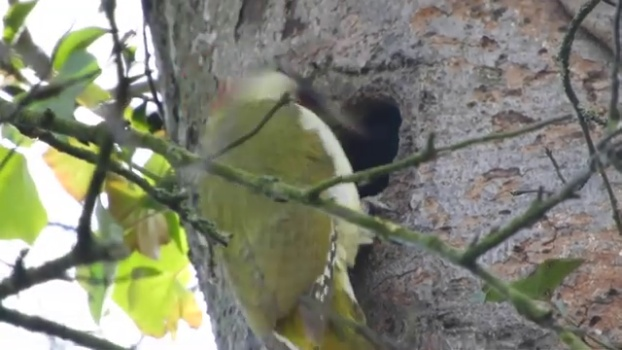

##########
- wildlife-video.mp4/13 SIM=0.577155
-  {'extracted_frame_path': 'extracted_frames/frame_13.jpg', 'mid_time_ms': 80840.0, 'transcript': ' But in spring it is nest building that is vitally important and high up in the canopy', 'video_path': 'wildlife-video.mp4', 'video_segment_id': 13}


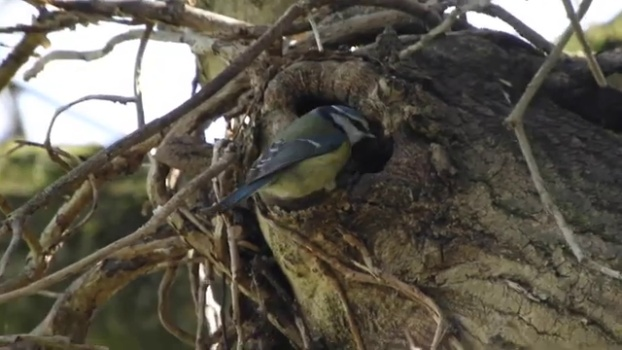

##########
- wildlife-video.mp4/18 SIM=0.614271
-  {'extracted_frame_path': 'extracted_frames/frame_18.jpg', 'mid_time_ms': 105320.0, 'transcript': ' Rose ringed parakeets.', 'video_path': 'wildlife-video.mp4', 'video_segment_id': 18}


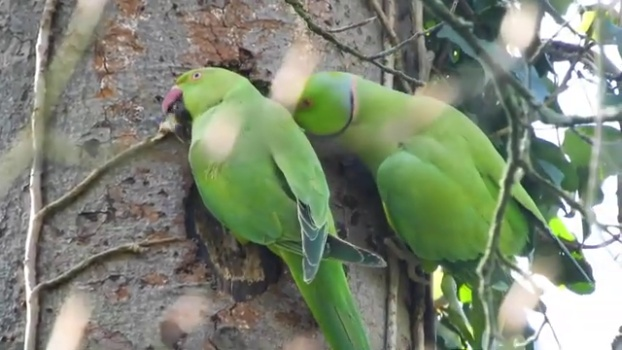

##########
- wildlife-video.mp4/7 SIM=0.655822
-  {'extracted_frame_path': 'extracted_frames/frame_7.jpg', 'mid_time_ms': 47120.0, 'transcript': ' hear the birds.', 'video_path': 'wildlife-video.mp4', 'video_segment_id': 7}


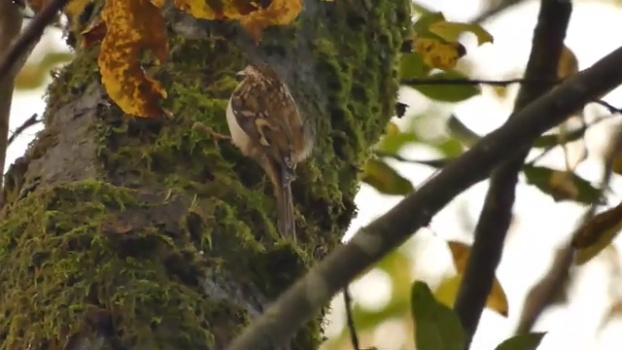

##########
- wildlife-video.mp4/14 SIM=0.658431
-  {'extracted_frame_path': 'extracted_frames/frame_14.jpg', 'mid_time_ms': 86400.0, 'transcript': ' One species is taking advantage of the peace and quiet.', 'video_path': 'wildlife-video.mp4', 'video_segment_id': 14}


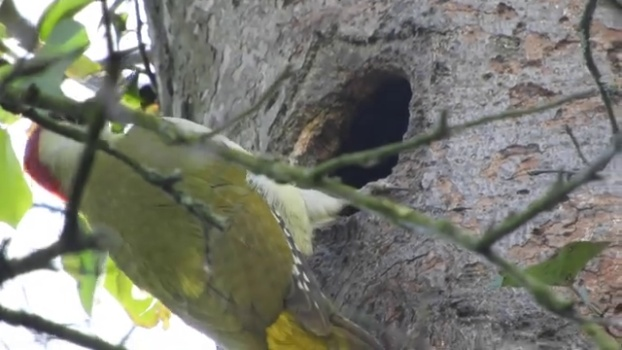

In [16]:
results = search("Green bird making a nest", 5)

Creating a function to return the video segment plus few seconds before and after the scene

In [28]:
def get_video_segment_from_meta(metadata, duration, output_path="tmp.mp4"):
  video_path = metadata["video_path"]
  video_segment_id = metadata["video_segment_id"]
  mid_time_ms = metadata["mid_time_ms"]


  clip = VideoFileClip(video_path)
  video_length = clip.duration * 1000

  delta_time = duration * 1000 / 2
  start_time_ms = max(mid_time_ms - delta_time, 0)
  end_time_ms = min(mid_time_ms + delta_time, video_length)

  subclip = clip.subclip(start_time_ms / 1000, end_time_ms / 1000)
  subclip.write_videofile(output_path)

  return output_path

Creating a function to play the video in Colab notebook

In [26]:
def play_video(path):
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

getting the most relevant result from the search - sorted list, i.e most relevant would be the first index

In [29]:
most_relevant_clip = get_video_segment_from_meta(results[0][0].metadata, 5)

t:  15%|█▌        | 344/2271 [01:46<00:42, 45.81it/s, now=None]

Moviepy - Building video tmp.mp4.
MoviePy - Writing audio in tmpTEMP_MPY_wvf_snd.mp3



t:  15%|█▌        | 344/2271 [01:46<00:42, 45.81it/s, now=None]

MoviePy - Done.
Moviepy - Writing video tmp.mp4




t:  15%|█▌        | 344/2271 [01:50<00:42, 45.81it/s, now=None]

Moviepy - Done !
Moviepy - video ready tmp.mp4


Play video segment

In [30]:
play_video(most_relevant_clip)

Creating a function to perfrom search and playing the most relevant result at the same time

In [35]:
def search_and_play(query):
  results = search(query, 1, show=False)
  most_relevant_clip = get_video_segment_from_meta(results[0][0].metadata, 5)
  return play_video(most_relevant_clip)

Testing the whole RAG system

In [36]:
search_and_play("Deers fighting")

t:  15%|█▌        | 344/2271 [07:39<00:42, 45.81it/s, now=None]

Moviepy - Building video tmp.mp4.
MoviePy - Writing audio in tmpTEMP_MPY_wvf_snd.mp3



t:  15%|█▌        | 344/2271 [07:40<00:42, 45.81it/s, now=None]

MoviePy - Done.
Moviepy - Writing video tmp.mp4




t:  15%|█▌        | 344/2271 [07:44<00:42, 45.81it/s, now=None]

Moviepy - Done !
Moviepy - video ready tmp.mp4


In [37]:
search_and_play("small black bird in the water")

t:  15%|█▌        | 344/2271 [08:57<00:42, 45.81it/s, now=None]

Moviepy - Building video tmp.mp4.
MoviePy - Writing audio in tmpTEMP_MPY_wvf_snd.mp3



t:  15%|█▌        | 344/2271 [08:58<00:42, 45.81it/s, now=None]

MoviePy - Done.
Moviepy - Writing video tmp.mp4




t:  15%|█▌        | 344/2271 [09:01<00:42, 45.81it/s, now=None]

Moviepy - Done !
Moviepy - video ready tmp.mp4
